## Binary files and raw data

SpikeGLX stores raw data in binary files **.bin** accompanied by a text file **.meta** that contains information about the recording. It is useful to understand how data are stored and how to access raw data directly.

Binary files are not only used by SpikeGLX, they are common for many imaging and data acquisition applications. They are specially good for cases when you want to record data fast, and without compression, so you can quickly access it.

In binary files, data are stored sample by sample, with **16-bit precision**. This makes it possible to record streaming data.

<img src="../images/bin_stream.png" width="400">

Data from each timepoint are close to each other for all channels so we can reshape these data as **2D array**
 with shape **NUM_SAMPLES x NUM_CHANNELS** 

<img src="../images/bin_array.png" width="200">

One advantage of binary files is that one can access a data chunk of time quickly **without** loading it into memory which would not be possible for long recordings from many channels.

This is called **memory mapping**. The python _numpy_ module has a function to perform memory mapping.

In [ ]:
import numpy as np # to map the file and handle data types
from pathlib import Path # to find the file and get the number of samples

foldername = Path('./data/AL032')  # path to folder containing the binary file
# try to find the binary file (has extension .bin)
fname = list(foldername.rglob('*.bin'))
if not len(fname): # display an error message if the file is not found.
    raise(ValueError(f'Could not find the file in folder {foldername}'))
else:
    fname = fname[0] # the full path to the file

dtype = np.dtype('int16')  # for spikeglx records data in int16 format (16 zeros or ones describe each sample)
nchannels = 97 # there are 97 channels in the example dataset (385 for a single 1.0 or 2.0 Neuropixels probe)


# calculate the sample size from the filesize - using "fname.stat().st_size"

nsamples = fname.stat().st_size/(nchannels*dtype.itemsize)
# use the memmap function to read the file in the correct shape
dat = np.memmap(fname,
                mode='r', # open in read mode (safe)
                dtype = dtype,
                shape = (int(nsamples),int(nchannels)))
print(f'Loaded {fname.name} with {dat.shape[0]} samples and {dat.shape[1]} channels.')

SpikeGLX stores the configurations and parameters used in the recording in **.meta** files. 

These files are simply text files so we can read the number of stored samples directly from these files. 

For more information about these files look at the [**SpikeGLX documentation**](https://billkarsh.github.io/SpikeGLX/Sgl_help/Metadata_Help.html)


In [ ]:
meta_fname = list(foldername.rglob('*.meta'))[0] # find the metadata file

nchannels = None
with open(meta_fname,'r') as fd:
    for line in fd.readlines():
        if 'nSavedChans' in line: # find a line with nSavedChans
            print(line)
            # split on '=' and get the number
            nchannels = int(line.split('=')[-1])
print(f'Read the number of channels [{nchannels}] from the metadata file.')

**Summary:**

SpikeGLX will output *.meta* and *.bin* files for each recording stream. 

These can be using _numpy_ and _python_ easily and we do not have to load the entire file at once when using memory mapping.

---

It helps to have a fast drive (like an _NVME_ or _SSD_ drive) to be able to map data quickly.

We included a function **load_spikeglx_binary** to parse and load SpikeGLX binary files.


In [ ]:
from helpers import load_spikeglx_binary
dat,meta = load_spikeglx_binary(fname)

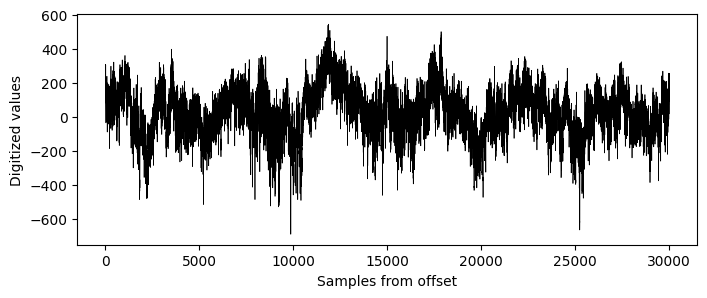

In [86]:
# we can now plot a subset of the data
seconds_to_plot = 1
offset = 20

data_chunk = dat[int(offset*sampling_rate):int((offset+seconds_to_plot)*sampling_rate)]

import pylab as plt  # for plotting

# if on a notebook use the ipympl magic to have interactive figures
#%matplotlib ipympl
# you can also use "widget" of "qt"

plt.figure(figsize=[8,3])
plt.plot(data_chunk[:,0],'k',lw = 0.5)
plt.ylabel('Digitized values')
plt.xlabel('Samples from offset');

We don't have the data in the correct units. That is because spikeGLX stores samples in digitized values, those values must be **converted to voltage units** if we want to interpret the amplitude of the signals.

The **conversion factor** can be retrieved from the **.meta** file following the formula:

    data_volts = data_value * (digitizer_range_volts / digitizer_max_value) / gain

The gain depends on the **probe type**.

 - **NP2** - production (type 2013) have gain **100**.
 - **NP2a** - development (type 21 and 24) it is **80**
 - **NP1** have adjustable gain per channel. The value is _imChan0apGain + the fourth col
 of the imro_ table.

[Check the SpikeGLX_Datafile_Tools](https://github.com/jenniferColonell/SpikeGLX_Datafile_Tools) for more scripts and ways to load raw data.


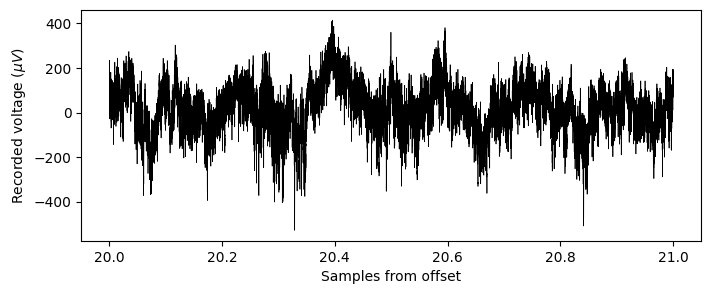

In [91]:
digitizer_range_volts = meta['imAiRangeMax'] # of niAiRangeMax for NI streams or obAiRangeMax for onebox streams
digitizer_max_value = meta['imMaxInt'] # or niMaxInt for NI streams or obMaxInt for onebox stream

# the gain is fixed for NP2 but variable for 1.0 probes
if int(meta['imDatPrb_type']) in [21,24]:
    gain = 80
elif int(meta['imDatPrb_type']) in [2013]:
    gain = 100

conversion_factor = digitizer_range_volts/digitizer_max_value/gain * 1e6 # convert to microvolt my multiplying by 1e6

data_chunk_mvolt = data_chunk*conversion_factor 

# Plot the data in the corrected units
plt.figure(figsize=[8,3])
t = offset + np.arange(len(data_chunk_mvolt))/meta['imSampRate']
plt.plot(t,data_chunk_mvolt[:,0],color = 'k', lw = 0.5);
plt.ylabel('Recorded voltage ($\mu V$)')
plt.xlabel('Samples from offset');

In [ ]:
# plotting multiple channels
channel_offset = 500
channels_to_plot = np.arange(10)
plt.figure()
plt.plot(t,data_chunk_mvolt[:,channels_to_plot]+np.arange(len(channels_to_plot))*500);

From the above cell, you can notice that data from individual channels are offset by different values. That is because each channels might have different offsets and one way of solving is filtering. 

We will apply a bandpass filter to remove frequencies below 300Hz and above 12kHz. There are differnet filters, we'll apply a [butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter) using _filtfilt_ that will prevent **phase-shifting**.


In [ ]:
# define a function to perform the filtering (isolate the AP band)
def filter_data(X, band = [300,12000],btype = 'band'):
    from scipy.signal import butter, filtfilt
    Wn = np.array(band) / (meta['imSampRate']/2.) # define the filter band
    b, a = butter(3, Wn, btype = btype) # third order butterworth filter
    return filtfilt(b,a,X, axis = 0) # use 2 passes

fdata_chunk = filter_data(data_chunk_mvolt)

# plotting multiple channels
channel_offset = 500
channels_to_plot = np.arange(10)
plt.figure()
plt.plot(t,fdata_chunk[:,channels_to_plot]+np.arange(len(channels_to_plot))*500);

Lets look at all channels using ``imshow`` setting _voltage_ as _color_.

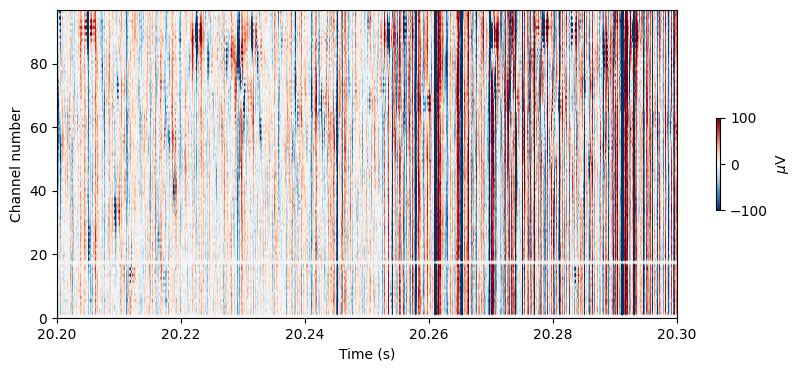

In [92]:
plt.figure(figsize = [10,4])
plt.imshow(fdata_chunk.T,aspect = 'auto',
            clim = [-100,100], # color limits
            cmap  = 'RdBu_r',
            extent = [offset, offset+seconds_to_plot,0,fdata_chunk.shape[1]])
plt.colorbar(shrink=0.3,label='$\mu$V')
plt.xlabel('Time (s)')
plt.ylabel('Channel number')
plt.xlim([offset+0.2,offset+0.3]);

In some channels seem to fluctuate at the same time. Those fluctuations make it harder to isolate spiking and can be caused by animal movement, changes in ground voltage, **artifacts**, etc. 

We can subtract the median voltage at each time point: known as **C**ommon **A**verage **R**eferencing to remove these fluctuations.

In [ ]:
# plot the median of all channels 
plt.figure(figsize = [8,2])
plt.plot(t, np.median(fdata_chunk,axis = 1),color = 'k',lw = 0.1)
plt.ylabel('Median across all channels')
plt.xlabel('Time (s)');

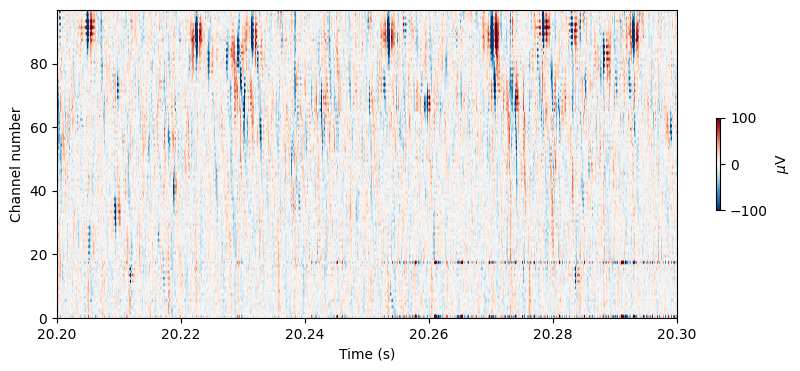

In [83]:
# plot data with CAR correction
plt.figure(figsize = [10,4])
# remove the median voltage across all channels to perform global CAR
car_data = (fdata_chunk.T - np.median(fdata_chunk,axis = 1)).T

plt.imshow(car_data.T ,aspect = 'auto',
            clim = [-100,100], # color limits
            cmap  = 'RdBu_r',
            extent = [offset, offset+seconds_to_plot,0,fdata_chunk.shape[1]])
plt.colorbar(shrink=0.3,label='$\mu$V')
plt.xlabel('Time (s)')
plt.ylabel('Channel number')
plt.xlim([offset+0.2,offset+0.3]);